## Anomaly Detection similar to Twitter's Seasonal Hybrid ESD

The basis of this approach is to decompose the signal into a trend, seasonal and residual component, then the Generalised Extreme Stundentized Deviate (ESD) to find up to $n$ anomalies within a given threshold. 

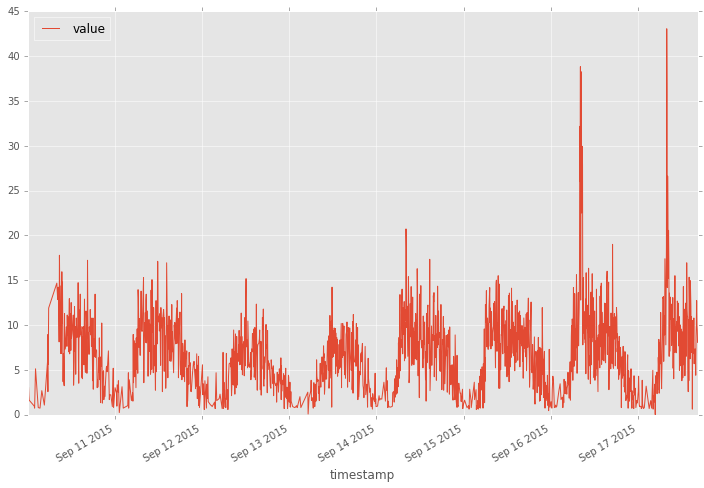

In [235]:
import pandas as pd
import scipy as sp
from scipy.stats import norm

import numpy as np
import statsmodels.api as sm
from PyAstronomy import pyasl
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 2000

matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.style.use('ggplot')

#fd = '~/git/NAB/data/realTweets/Twitter_volume_GOOG.csv'
fd = '~/git/NAB/data/realTraffic/occupancy_t4013.csv'
df = pd.read_csv(fd, 
    index_col=0, 
    parse_dates=True
)
#df = df['2015-04-10':]
df = df['2015-09-10':]
df.plot()

In [268]:
df.head(5)

,value
timestamp,
2015-09-10 00:03:00,2.61
2015-09-10 00:13:00,3.06
2015-09-10 00:18:00,2.11
2015-09-10 00:23:00,1.61
2015-09-10 01:48:00,0.94


So far so good, we have a noisy signal, with some clear daily periodicity. The records arrive at a rate of roughly 1 every 4-10 minutes. Occationally a record is missing altogether. Real world data is noisy so we have to handle that.

### Probability distribution of raw signal

In this case a Normal distribution is not too bad, as we will see latter there is not a significant trend in this example which can have the biggest impact on a good fit.  

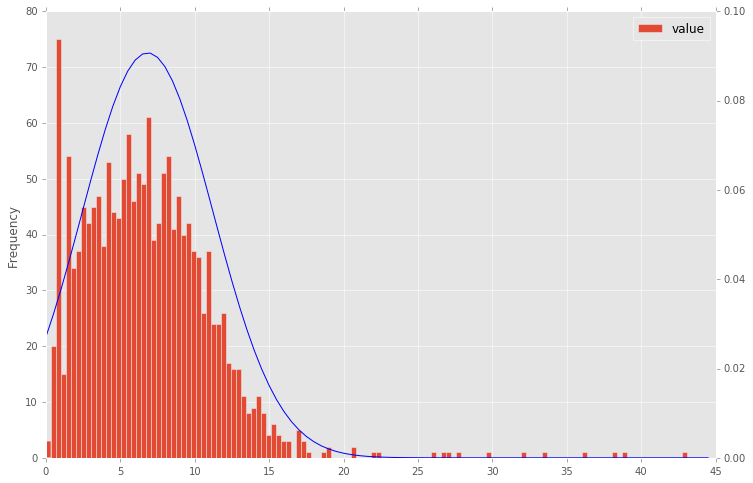

In [237]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
df.plot.hist( stacked=True, bins=128, ax=ax1 )

xmin,xmax,ymin,ymax=plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
plt.plot(x_axis, norm.pdf(x_axis,df.mean(),df.std()),color='blue')

### Seasonal decomposition

This is where the raw signal is plit into it's components, but first we have to handle noisy and missing data, here we:
 - Resample, aggregate the signal into fixed time buckets calculated using the mean
 - Intermolate filling any missing holes based on surronding data

This gives the plot below. It is importaing to choose a correct basis for resampling and looking for seasonality. I've chosen to keep the signal samples pretty close to the original (15min), then use 24hrs worth of samples when looking for seasonality. This keeps the signal close to the original, but maximised the seasonal component.  

*Note:* I believe twitter uses a polunomial fit to extract the trend, the 'statsmodels' method uses moving averages / convolution. Hence the delay before the trend line starts.

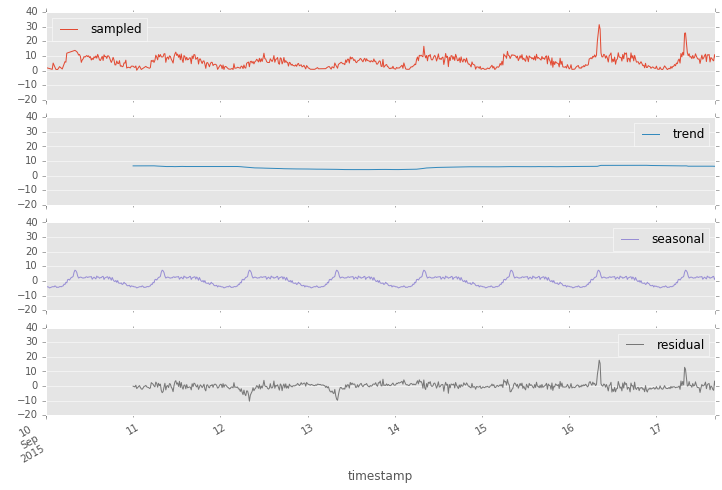

In [287]:
s_rule = '15T' #15 mins
n_sample = 96  #Number of 15mins in 24 hours  
sf = df.resample(s_rule).mean()
sf.interpolate(method='time',inplace=True)
res = sm.tsa.seasonal_decompose(sf, two_sided=False, freq=n_sample)
rf = pd.concat([sf, res.trend, res.seasonal, res.resid], axis=1)
rf.columns = ['sampled', 'trend', 'seasonal', 'residual']
fig = rf.plot(subplots=True,sharey=True)  

Not looking at the 'residual' signal probability distribution we see it is a much better fit to a Normal distribution. 

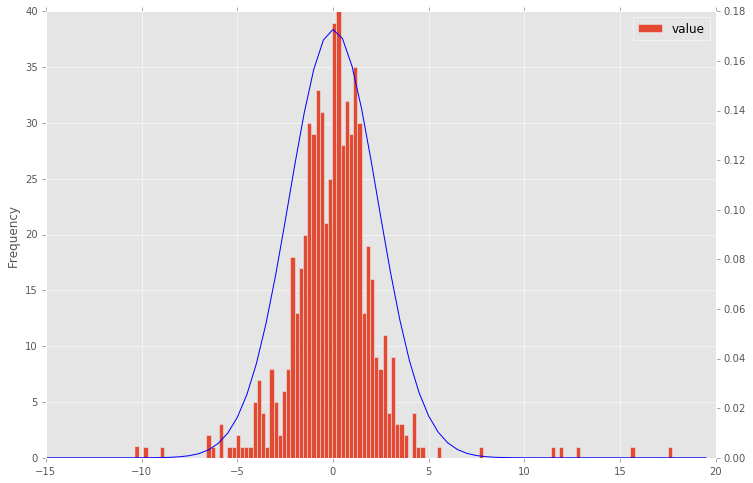

In [288]:
sf = res.resid
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax2.grid(False)
sf.plot.hist( stacked=True, bins=128, ax=ax1 )

xmin,xmax,ymin,ymax=plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
plt.plot(x_axis, norm.pdf(x_axis,sf.mean(),sf.std()),color='blue')

With that established we can start looking for anomalies. This is done with Generalised ESD. Anomalies are marked in the diagram below.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f77a6a8b8d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f77aa19f710>], dtype=object)

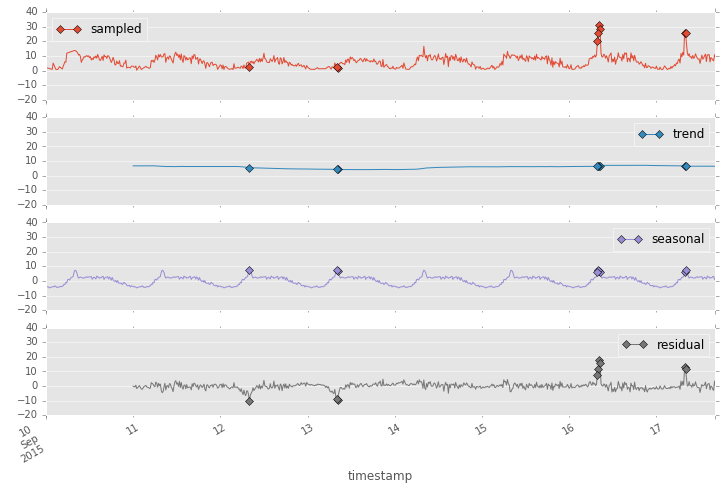

In [289]:
arr = rf['residual'][n_sample:]
nos, anomalies = pyasl.generalizedESD(arr, 10, 0.05, fullOutput=False)
mark = [x+n_sample for x in anomalies]
rf.plot( subplots=True, sharey=True, marker='D', markevery=mark )

In [305]:
mark.sort()
print( nos, mark )
rf.iloc[mark]

9 [224, 320, 321, 607, 608, 609, 610, 703, 704]


,sampled,trend,seasonal,residual
timestamp,,,,
2015-09-12 08:00:00,2.585000,5.601319,7.330492,-10.346811
2015-09-13 08:00:00,2.750000,4.365877,7.330492,-8.946369
2015-09-13 08:15:00,1.560000,4.343038,6.916500,-9.699538
2015-09-16 07:45:00,20.183333,6.429045,5.903473,7.850816
2015-09-16 08:00:00,25.870000,6.575512,7.330492,11.963996
2015-09-16 08:15:00,31.426667,6.766771,6.916500,17.743396
2015-09-16 08:30:00,28.313333,6.967292,5.774406,15.571636
2015-09-17 07:45:00,25.540000,6.783038,5.903473,12.853489
2015-09-17 08:00:00,25.703333,6.810069,7.330492,11.562772
